# Лабораторная работа 1. Метод главных компонент (PCA) и kNN

**Задача:** реализовать собственные классы `my_PCA` и `my_kNN`, применить их к распознаванию рукописных цифр MNIST.

In [5]:
import numpy as np
import os
import shutil
import gzip
from urllib import request as urllib_request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## I. Датасет MNIST

### 1. Загрузка данных

In [6]:
# ---- Функции загрузки MNIST (из mnist.py) ----

DEFAULT_SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' % (magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def extract_labels(f, one_hot=False, num_classes=10):
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' % (magic, f.name))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        if one_hot:
            return dense_to_one_hot(labels, num_classes)
        return labels

def maybe_download(filename, work_directory, source_url):
    if not os.path.exists(work_directory):
        os.makedirs(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        temp_file_name, _ = urllib_request.urlretrieve(source_url, None)
        shutil.copy(temp_file_name, filepath)
        with open(filepath, 'rb') as f:
            f.seek(0, 2)
            size = f.tell()
            print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

def read_MNIST_datasets(train_dir, one_hot=False, dtype=np.float32,
                        reshape=True, validation_size=5000, seed=None,
                        source_url=DEFAULT_SOURCE_URL):
    if not source_url:
        source_url = DEFAULT_SOURCE_URL
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    local_file = maybe_download(TRAIN_IMAGES, train_dir, source_url + TRAIN_IMAGES)
    with open(local_file, 'rb') as f:
        train_images = extract_images(f)
    local_file = maybe_download(TRAIN_LABELS, train_dir, source_url + TRAIN_LABELS)
    with open(local_file, 'rb') as f:
        train_labels = extract_labels(f, one_hot=one_hot)
    local_file = maybe_download(TEST_IMAGES, train_dir, source_url + TEST_IMAGES)
    with open(local_file, 'rb') as f:
        test_images = extract_images(f)
    local_file = maybe_download(TEST_LABELS, train_dir, source_url + TEST_LABELS)
    with open(local_file, 'rb') as f:
        test_labels = extract_labels(f, one_hot=one_hot)

    if not 0 <= validation_size <= len(train_images):
        raise ValueError('Validation size should be between 0 and {}. Received: {}.'.format(
            len(train_images), validation_size))

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    train = (train_images, train_labels)
    validation = (validation_images, validation_labels)
    test = (test_images, test_labels)
    return train, validation, test

def load_mnist(train_dir='MNIST-data'):
    return read_MNIST_datasets(train_dir)

In [7]:
train, validation, test = load_mnist()

X_train_img, y_train_all = train
X_val_img, y_val_all = validation
X_test_img, y_test_all = test

X_all = np.concatenate([X_train_img, X_val_img, X_test_img], axis=0)
y_all = np.concatenate([y_train_all, y_val_all, y_test_all], axis=0)

# Преобразуем картинки 28x28x1 в плоские вектора длины 784
X = X_all.reshape(X_all.shape[0], -1).astype(np.float64)
labels = y_all

print(f'Размер X: {X.shape}')
print(f'Размер labels: {labels.shape}')
print(f'Уникальные классы: {np.unique(labels)}')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Размер X: (70000, 784)
Размер labels: (70000,)
Уникальные классы: [0 1 2 3 4 5 6 7 8 9]


### 2. Визуализация примеров

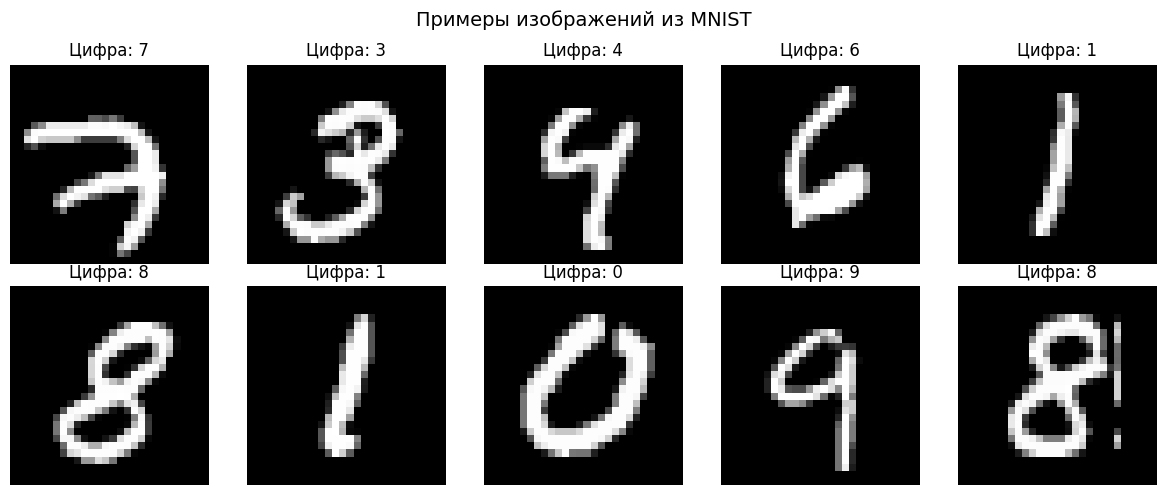

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Цифра: {labels[i]}')
    ax.axis('off')
plt.suptitle('Примеры изображений из MNIST', fontsize=14)
plt.tight_layout()
plt.show()

## II. Алгоритм PCA

### 1. Реализация класса my_PCA

In [9]:
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.eigenvalues_ = None
    
    def fit(self, X):
        # Шаг 1: Центрирование данных
        self.mean_ = np.mean(X, axis=0)
        X_c = X - self.mean_
        
        # Шаги 2-3: SVD-разложение
        # X_c = U * S * V^T
        # Собственные значения ковариационной матрицы: lambda = S^2 / (n-1)
        # Собственные векторы — строки V^T
        n = X.shape[0]
        U, S, Vt = np.linalg.svd(X_c, full_matrices=False)
        
        self.eigenvalues_ = (S ** 2) / (n - 1)
        
        if self.n_components is not None:
            self.components_ = Vt[:self.n_components]
            self.eigenvalues_ = self.eigenvalues_[:self.n_components]
        else:
            self.components_ = Vt
        
        return self
    
    def transform(self, X):
        # Шаг 4: Y = X_c * F
        X_c = X - self.mean_
        return X_c @ self.components_.T
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Применяем PCA ко всему датасету

In [10]:
pca_full = my_PCA()
pca_full.fit(X)

eigenvalues = pca_full.eigenvalues_
print(f'Всего компонент: {len(eigenvalues)}')
print(f'Первые 15 собственных значений: {eigenvalues[:15].round(2)}')

Всего компонент: 784
Первые 15 собственных значений: [334294.06 245433.43 210930.35 185337.36 167691.57 147670.3  112445.14
  99115.38  94612.54  80335.96  72259.91  69888.55  58552.71  58105.28
  54310.38]


### 2. Графики собственных значений и кумулятивной дисперсии

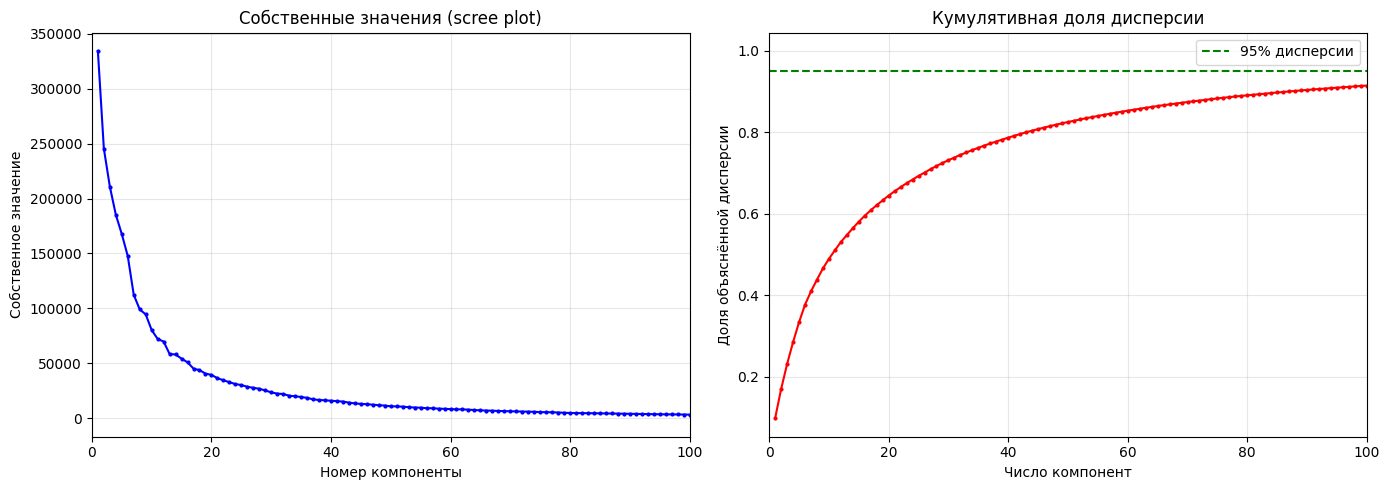

Доля дисперсии первых 15 компонент: 0.5805 (58.05%)
Число компонент для 95% дисперсии: 154


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'b-o', markersize=2)
ax1.set_xlabel('Номер компоненты')
ax1.set_ylabel('Собственное значение')
ax1.set_title('Собственные значения (scree plot)')
ax1.set_xlim(0, 100)
ax1.grid(True, alpha=0.3)

cumulative_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)
ax2.plot(range(1, len(eigenvalues) + 1), cumulative_ratio, 'r-o', markersize=2)
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% дисперсии')
ax2.set_xlabel('Число компонент')
ax2.set_ylabel('Доля объяснённой дисперсии')
ax2.set_title('Кумулятивная доля дисперсии')
ax2.set_xlim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Доля дисперсии первых 15 компонент: {cumulative_ratio[14]:.4f} ({cumulative_ratio[14]*100:.2f}%)')
n_95 = np.argmax(cumulative_ratio >= 0.95) + 1
print(f'Число компонент для 95% дисперсии: {n_95}')

**Вывод:** Собственные значения матрицы ковариации равны дисперсиям данных вдоль соответствующих главных компонент. Первые несколько компонент содержат основную часть информации, а остальные вносят незначительный вклад.

### 3. Визуализация в первых двух главных компонентах

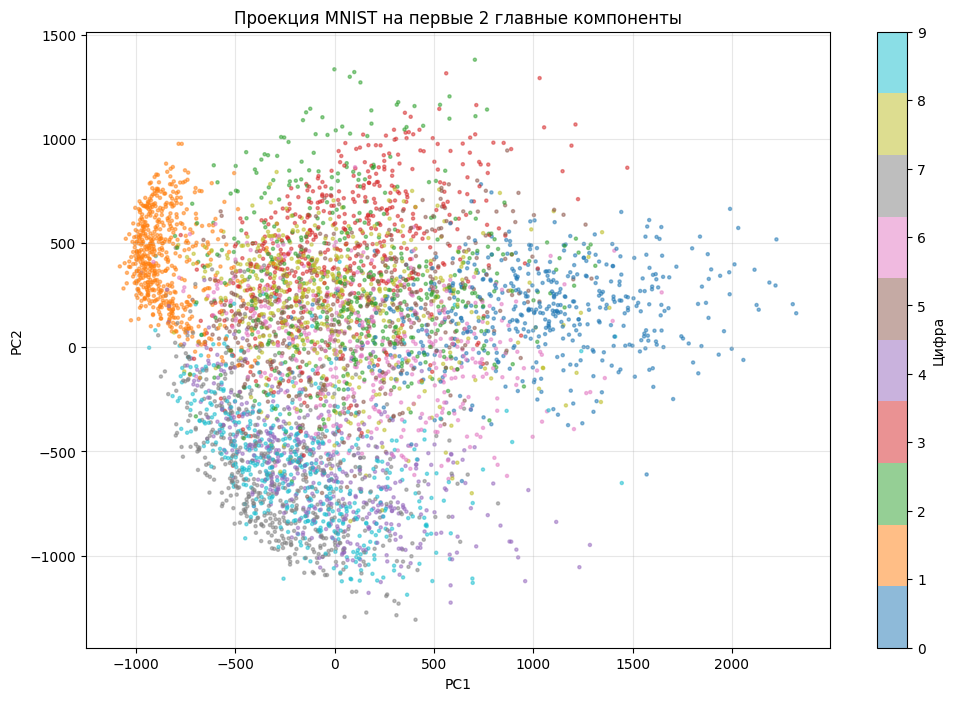

In [12]:
pca_2d = my_PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

n_samples_plot = 5000
idx = np.random.choice(len(X_2d), n_samples_plot, replace=False)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[idx, 0], X_2d[idx, 1],
                      c=labels[idx], cmap='tab10',
                      alpha=0.5, s=5)
plt.colorbar(scatter, label='Цифра')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Проекция MNIST на первые 2 главные компоненты')
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:** В двумерном пространстве первых двух главных компонент классы цифр значительно перекрываются — линейная разделимость в этих координатах плохая. Для хорошей классификации необходимо использовать больше компонент.

## III. Алгоритм kNN

### 1. Реализация класса my_kNN

In [13]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            k_nearest_idx = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_idx]
            counter = Counter(k_nearest_labels)
            predictions.append(counter.most_common(1)[0][0])
        return np.array(predictions)

### 2. Разбиение на обучающую и тестовую выборку

In [14]:
# Подвыборка для ускорения (kNN на полном MNIST очень долго)
np.random.seed(42)
sample_idx = np.random.choice(len(X), 12000, replace=False)
X_sample = X[sample_idx]
labels_sample = labels[sample_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, labels_sample, test_size=0.2, random_state=42
)

print(f'Обучающая выборка: {X_train.shape}')
print(f'Тестовая выборка: {X_test.shape}')

Обучающая выборка: (9600, 784)
Тестовая выборка: (2400, 784)


### 3. Классификация kNN без PCA

In [15]:
knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)

print('Предсказание на тестовой выборке...')
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Точность kNN (k=5) без PCA: {acc:.4f} ({acc*100:.2f}%)')

Предсказание на тестовой выборке...
Точность kNN (k=5) без PCA: 0.9446 (94.46%)


### 4. Подбор оптимальных параметров: PCA + kNN

In [16]:
n_components_list = [1, 2, 5, 10, 15, 20, 30, 40, 50, 64]
n_neighbors_list = [1, 3, 5, 7, 10, 15, 20, 25, 30]

results = np.zeros((len(n_components_list), len(n_neighbors_list)))

for i, n_comp in enumerate(n_components_list):
    pca = my_PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    for j, n_neigh in enumerate(n_neighbors_list):
        knn = my_kNN(n_neighbors=n_neigh)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        results[i, j] = accuracy_score(y_test, y_pred)
        print(f'Компонент: {n_comp:3d}, Соседей: {n_neigh:3d} -> Точность: {results[i,j]:.4f}')

best_idx = np.unravel_index(np.argmax(results), results.shape)
best_comp = n_components_list[best_idx[0]]
best_neigh = n_neighbors_list[best_idx[1]]
best_acc = results[best_idx]
print(f'\nЛучший результат: {best_acc:.4f} при n_components={best_comp}, n_neighbors={best_neigh}')

Компонент:   1, Соседей:   1 -> Точность: 0.2504
Компонент:   1, Соседей:   3 -> Точность: 0.2608
Компонент:   1, Соседей:   5 -> Точность: 0.2671
Компонент:   1, Соседей:   7 -> Точность: 0.2754
Компонент:   1, Соседей:  10 -> Точность: 0.2838
Компонент:   1, Соседей:  15 -> Точность: 0.2888
Компонент:   1, Соседей:  20 -> Точность: 0.2858
Компонент:   1, Соседей:  25 -> Точность: 0.2917
Компонент:   1, Соседей:  30 -> Точность: 0.2921
Компонент:   2, Соседей:   1 -> Точность: 0.3742
Компонент:   2, Соседей:   3 -> Точность: 0.3917
Компонент:   2, Соседей:   5 -> Точность: 0.4096
Компонент:   2, Соседей:   7 -> Точность: 0.4154
Компонент:   2, Соседей:  10 -> Точность: 0.4283
Компонент:   2, Соседей:  15 -> Точность: 0.4283
Компонент:   2, Соседей:  20 -> Точность: 0.4429
Компонент:   2, Соседей:  25 -> Точность: 0.4454
Компонент:   2, Соседей:  30 -> Точность: 0.4437
Компонент:   5, Соседей:   1 -> Точность: 0.6704
Компонент:   5, Соседей:   3 -> Точность: 0.7033
Компонент:   5, Сосе

### Графики зависимости точности

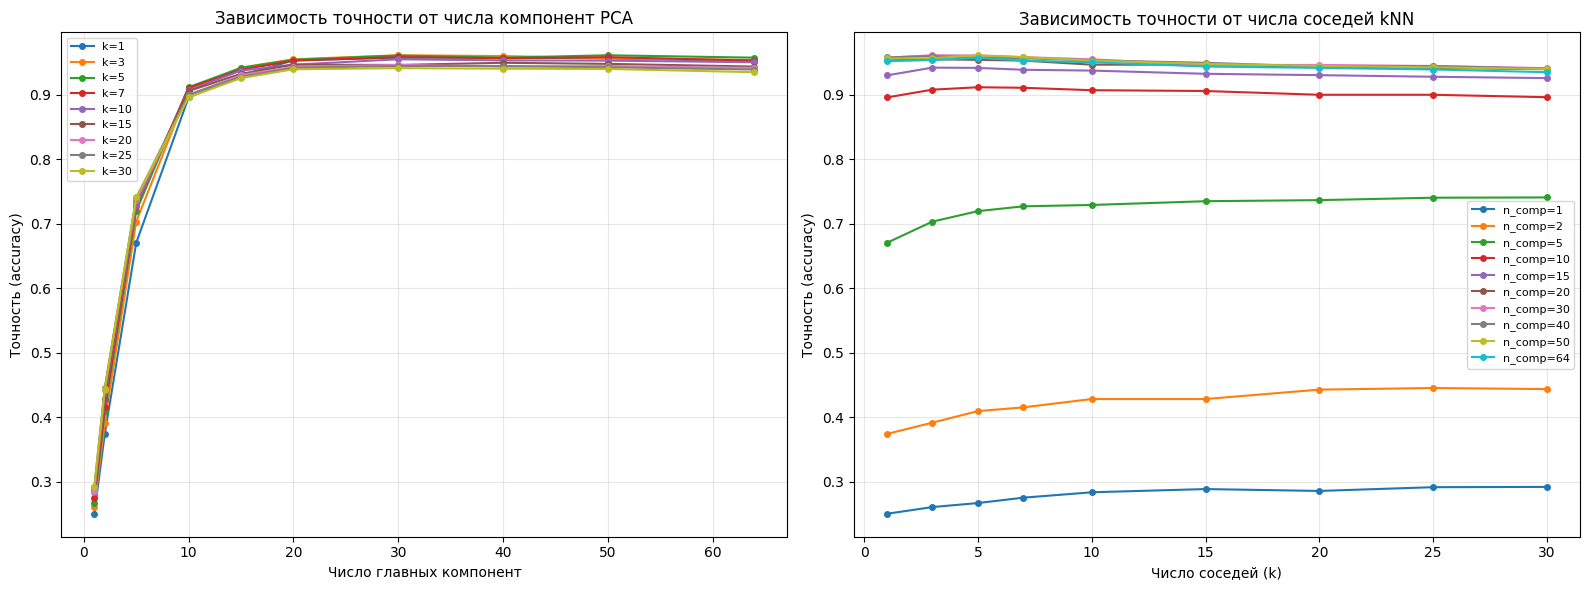

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for j, n_neigh in enumerate(n_neighbors_list):
    ax1.plot(n_components_list, results[:, j], '-o', markersize=4, label=f'k={n_neigh}')
ax1.set_xlabel('Число главных компонент')
ax1.set_ylabel('Точность (accuracy)')
ax1.set_title('Зависимость точности от числа компонент PCA')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

for i, n_comp in enumerate(n_components_list):
    ax2.plot(n_neighbors_list, results[i, :], '-o', markersize=4, label=f'n_comp={n_comp}')
ax2.set_xlabel('Число соседей (k)')
ax2.set_ylabel('Точность (accuracy)')
ax2.set_title('Зависимость точности от числа соседей kNN')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Тепловая карта точности

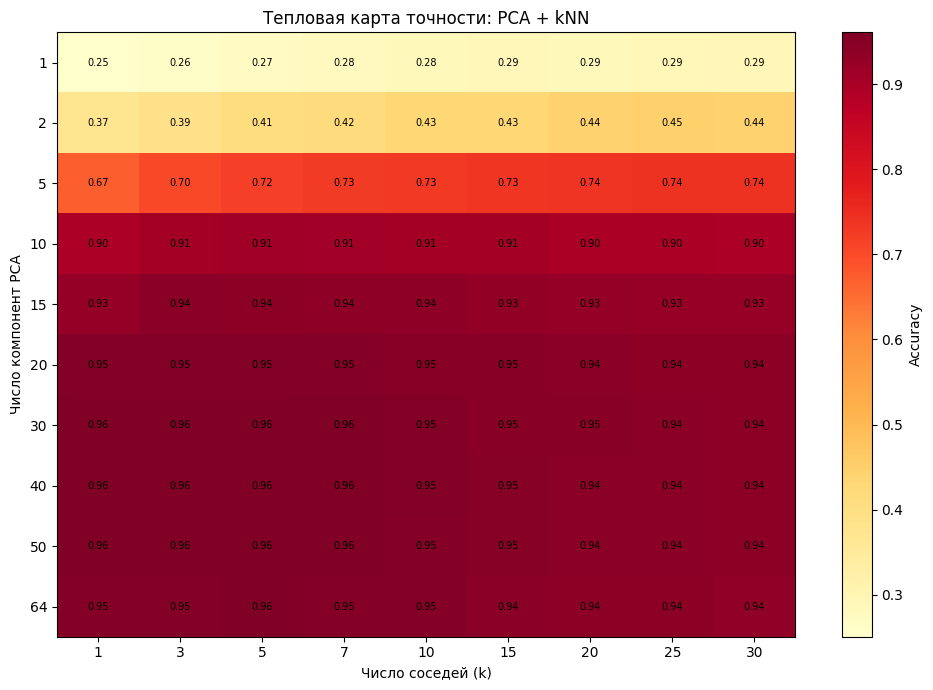

In [18]:
plt.figure(figsize=(10, 7))
plt.imshow(results, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Accuracy')
plt.xticks(range(len(n_neighbors_list)), n_neighbors_list)
plt.yticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Число соседей (k)')
plt.ylabel('Число компонент PCA')
plt.title('Тепловая карта точности: PCA + kNN')

for i in range(len(n_components_list)):
    for j in range(len(n_neighbors_list)):
        plt.text(j, i, f'{results[i,j]:.2f}', ha='center', va='center', fontsize=7)

plt.tight_layout()
plt.show()

## Выводы

1. **PCA** позволяет значительно снизить размерность данных MNIST (с 784 до ~15-50 компонент), сохраняя основную часть дисперсии.

2. **В двумерном пространстве** первых двух главных компонент классы цифр сильно перекрываются — линейная разделимость плохая.

3. **kNN** даёт высокую точность распознавания рукописных цифр (~95%+ на исходных данных).

4. **PCA + kNN:** применение PCA перед kNN ускоряет классификацию и может улучшить точность за счёт удаления шума. Оптимальное число компонент обычно 20–50, оптимальное число соседей — 3–7.

5. Слишком малое число компонент приводит к потере информации, слишком большое число соседей «размывает» границы классов — оба случая снижают точность.